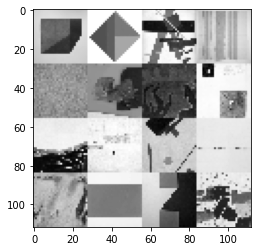

(20, 28, 28, 1)

In [1]:
import glob
import cv2
from matplotlib.pyplot import figure
import keras
from keras import backend as K, layers
from keras.losses import mse
from keras import layers
import numpy as np
from keras.api import keras
import tensorflow as tf
from matplotlib import pyplot as plt
import os


# Download dataset from here: https://www.kaggle.com/greg115/abstract-art
# Unzip into abstract_art_512 directory
class AbstractArtDataset:
    # Source: https://www.kaggle.com/greg115/abstract-art
    def __init__(self, path, size=28, greyscale=False):
        self.greyscale = greyscale
        self.size = size
        self.path = path
        self.images = []
        self.artists = []
        self.df = self._load()

    def visualise(self, inx=0, grid_size=4):
        grid = np.array(self.images[inx:inx + (grid_size * grid_size)])
        index, height, width, channels = grid.shape
        grid = (
            grid.reshape(grid_size, grid_size, self.size, self.size, channels)
                .swapaxes(1, 2)
                .reshape(self.size * grid_size, self.size * grid_size, channels)
        )
        figure(figsize=(4, 4))
        plt.imshow(grid, cmap='gray')
        plt.show()

    def _load(self):
        for path in list(glob.glob(self.path + "/*")):
            _, artist, _ = os.path.basename(path).split("_")
            img = cv2.imread(path, 1)
            img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
            if self.greyscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img.reshape((self.size, self.size, 1))
            self.images.append(img)
            self.artists.append(artist)
        return np.array(self.images)


art = AbstractArtDataset("./abstract_art_512", 28, True)
art.visualise()
art.df.shape

In [2]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512
LATENT_SIZE = 128
EPOCHS = 2
VAE_PATH = './vae'
WGAN_PATH = './wgan'


train_images = art.df.astype("float32")
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
dataset = tf.data.Dataset.from_tensor_slices((train_images - 127.5) / 127.5)
dataset = dataset.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE)

Number of examples: 20
Shape of the images in the dataset: (28, 28, 1)


2022-03-27 13:12:51.580792: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def conv_block(
        x,
        filters,
        activation,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding="same",
        use_bias=True,
        use_bn=False,
        use_dropout=False,
        drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def upsample_block(
        x,
        filters,
        activation,
        kernel_size=(3, 3),
        strides=(1, 1),
        up_size=(2, 2),
        padding="same",
        use_bn=False,
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit
# Not used, ran out of time :(
def residual_block(x, kernel_size, filters):
    fx = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Conv2D(filters, kernel_size, padding='same')(fx)
    out = layers.Add()([x, fx])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)
    return out

In [4]:
def encoder_block(input_layer):
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(input_layer)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)

    return x

In [5]:
def generative_model(latent_size):
    noise = layers.Input(shape=(latent_size,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = layers.Cropping2D((2, 2))(x)

    return keras.models.Model(noise, x, name="generator")

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        # override the inherited .call(self, inputs) method
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))  # N(0, 1)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # N(mu, sigma)


def get_autoencoder(img_shape, latent_size, generator, variable=False):
    img_input = layers.Input(shape=img_shape)
    x = encoder_block(img_input)
    if variable:
        z_mean = layers.Dense(latent_size, name="z_mean")(x)
        z_log_var = layers.Dense(latent_size, name="z_log_var")(x)
        z = Sampling()((z_mean, z_log_var))
    else:
        z = layers.Dense(latent_size, name="z")(x)
    encoder = keras.models.Model(img_input, z, name="encoder")
    outputs = generator(z)
    ae = keras.models.Model(img_input, outputs, name="autoencoder")

    # Loss approach from
    # https://gist.github.com/tik0/6aa42cabb9cf9e21567c3deb309107b7
    reconstruction_loss = mse(img_input, outputs)  # xhat should match x
    reconstruction_loss = 784 * K.mean(reconstruction_loss)
    if variable:
        variable = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        ae.add_loss(variable)
        ae.add_metric(variable, name='kl_loss', aggregation='mean')

    # Set up our losses on the model, and create them as metrics too.
    # The Model's loss is the sum of the two losses.
    ae.add_loss(reconstruction_loss)
    ae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

    return ae, encoder

In [7]:
class WGAN(keras.Model):
    def __init__(
        self,
        img_shape,
        latent_size,
        generator,
        generator_optimizer,
        discriminator_optimizer,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = self.get_discriminator(img_shape)
        self.discriminator.summary()
        self.generator = generator
        self.latent_size = latent_size
        self.discriminator_steps = discriminator_extra_steps
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.gradient_penalty_weight = gp_weight

    def get_discriminator(self, shape):
        img_input = layers.Input(shape=shape)
        x = encoder_block(img_input)
        x = layers.Dense(1)(x)
        return keras.models.Model(img_input, x, name="discriminator")

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def generator_loss(self, fake_img):
        return -tf.reduce_mean(fake_img)

    def discriminator_loss(self, real_img, fake_img):
        real_loss = tf.reduce_mean(real_img)
        fake_loss = tf.reduce_mean(fake_img)
        return fake_loss - real_loss

    def compile(self):
        super(WGAN, self).compile()

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.discriminator_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_size)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.discriminator_loss(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gradient_penalty_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.discriminator_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_size))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.generator_loss(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.generator_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [8]:
class ModelMonitor(keras.callbacks.Callback):
    def __init__(self, generator, img_shape, latent_size, path, size):
        super().__init__()
        self.size = size
        self.generator = generator
        self.img_shape = img_shape
        self.latent_size = latent_size
        self.path = path
        os.makedirs(path, exist_ok=True)
        os.makedirs(path + '/epochs', exist_ok=True)
        os.makedirs(path + '/checkpoints', exist_ok=True)

    def on_epoch_end(self, epoch, logs=None, show_frequency=1):
        random_latent_vectors = tf.random.normal(shape=(self.size * self.size, self.latent_size))
        generated_images = self.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5
        grid = np.array(generated_images)
        grid = (
            grid.reshape(self.size, self.size, self.img_shape[0], self.img_shape[0])
                .swapaxes(1, 2)
                .reshape(self.img_shape[0] * self.size, self.img_shape[0] * self.size)
        )
        plt.figure(figsize=(8, 8))
        plt.imsave('{}/epochs/{}.png'.format(self.path, epoch), grid, cmap='gray', vmin=0, vmax=255)
        if epoch % show_frequency == 0:
            plt.imshow(grid, cmap='gray', vmin=0, vmax=255)
            plt.show()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 32, 32, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   1664        ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)      (None, 16, 16, 64)   0           ['conv2d_3[0][0]']               
                                                                                        

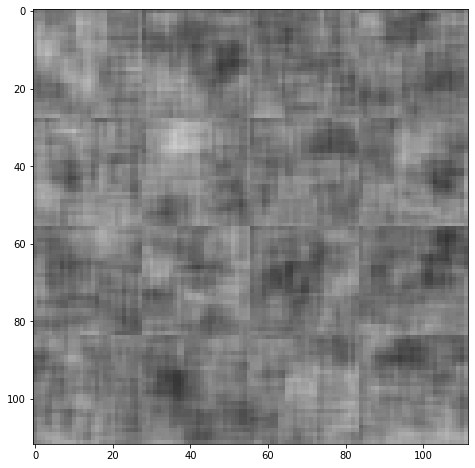

1/1 [==============================] - 1s 1s/step - loss: 626.1749 - mse_loss: 626.1749
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 239.3383 - mse_loss: 239.3383

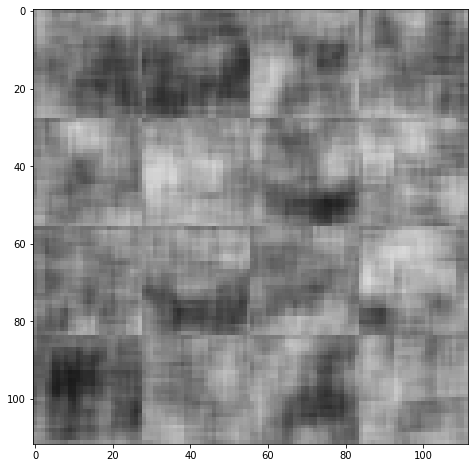

1/1 [==============================] - 0s 321ms/step - loss: 239.3383 - mse_loss: 239.3383


In [9]:
# AE Method =================================================================
generator = generative_model(LATENT_SIZE)
ae_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
ae, encoder = get_autoencoder(IMG_SHAPE, LATENT_SIZE, generator)
ae.compile(ae_optimizer)
ae.summary()
callback = ModelMonitor(generator, IMG_SHAPE, LATENT_SIZE, VAE_PATH, 4)
ae.fit(dataset, callbacks=[callback], epochs=EPOCHS)

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 32, 32, 1)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 64)   1664        ['zero_padding2d_1[0][0]']       
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     (None, 16, 16, 64)   0           ['conv2d_10[0][0]']    

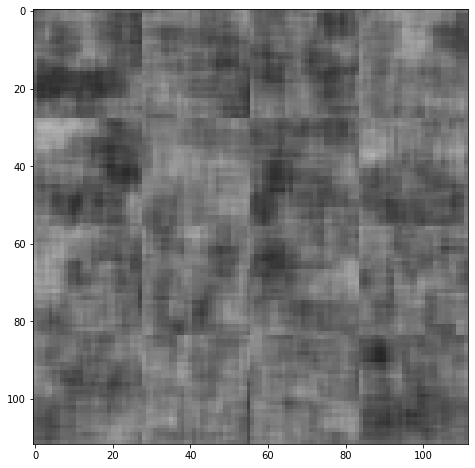

1/1 [==============================] - 1s 1s/step - loss: 604.7096 - kl_loss: 2.5825e-04 - mse_loss: 604.7094
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 549.5521 - kl_loss: 0.0027 - mse_loss: 549.5494

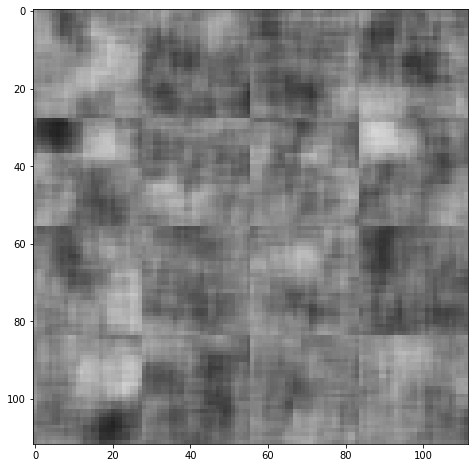

1/1 [==============================] - 0s 331ms/step - loss: 549.5521 - kl_loss: 0.0027 - mse_loss: 549.5494


In [10]:
# VAE Method =================================================================
generator = generative_model(LATENT_SIZE)
vae_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae, encoder = get_autoencoder(IMG_SHAPE, LATENT_SIZE, generator, variable=True)
vae.compile(vae_optimizer)
vae.summary()
callback = ModelMonitor(generator, IMG_SHAPE, LATENT_SIZE, VAE_PATH, 4)
vae.fit(dataset, callbacks=[callback], epochs=EPOCHS)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_2 (Dense)             (None, 4096)              524288    
                                                                 
 batch_normalization_8 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_6 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                     

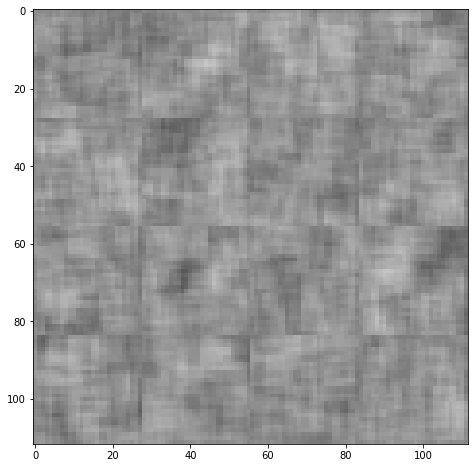

1/1 [==============================] - 6s 6s/step - d_loss: -250.1454 - g_loss: -0.7474
Epoch 2/2
1/1 [==============================] - ETA: 0s - d_loss: -2816.5488 - g_loss: -7.5827

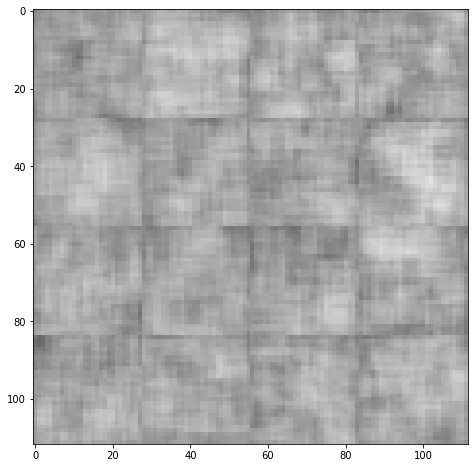

1/1 [==============================] - 1s 1s/step - d_loss: -2816.5488 - g_loss: -7.5827


In [11]:
# WGAN Method =================================================================
generator = generative_model(LATENT_SIZE)
generator.summary()
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
wgan = WGAN(
    img_shape=IMG_SHAPE,
    latent_size=LATENT_SIZE,
    generator=generator,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=generator_optimizer,
)
wgan.compile()
callback = ModelMonitor(generator, IMG_SHAPE, LATENT_SIZE, WGAN_PATH, 4)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[callback])